In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def quadratic_function(x):
    return -x**2 + 3*x + 2

In [6]:
quadratic_function(4.0)

-2.0

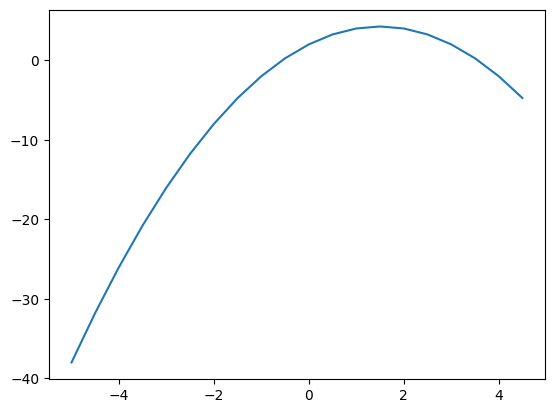

In [3]:
xs = np.arange(-5,5,0.5)
ys = quadratic_function(xs)
plt.plot(xs, ys)

In [4]:
h = 0.00000001
x = 0.0
approximate_derivative = (quadratic_function(x + h) - quadratic_function(x)) / h

print(f"Approximate derivative at x={x}: {approximate_derivative}")


Approximate derivative at x=0.0: 2.999999981767587


In [ ]:
#this is taking the derivatives with respect to multiple variables for a function with multiple inputs 



In [5]:
from graphviz import Digraph
import math

class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)

    def __radd__(self, other): # other + self
        return self + other

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad 
        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        #Why do we have to re-initialize the gradient here
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    nodes, edges = trace(root)
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR for left-to-right graph

    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

# Define the function with multiple inputs
def function(a, b, c):
    return a**2 + b**2 + c**2 + 3*a*b + 2*b*c + a*c

# Create Value objects for each input
a = Value(1.0, label='a')  # Example value for a
b = Value(2.0, label='b')  # Example value for b
c = Value(3.0, label='c')  # Example value for c

# Compute the function value
d = function(a, b, c)
d.label = 'd'

# Perform backpropagation to compute the gradients
d.backward()


# Visualize the computation graph
dot = draw_dot(d)
dot.render('computation_graph', format='png', view=True)  # Save and view the graph


'computation_graph.png'

In [53]:
scalar = Value(3.0)
scalar2 = Value(6.3)
print(scalar.__add__(scalar2))

Value(data=9.3, grad=0.0)


In [6]:
from graphviz import Digraph as gd
import graphviz
g = graphviz.Graph(format='png') 
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    nodes, edges = trace(root)
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR for left-to-right graph

    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

# Define the function with multiple inputs
def function(a, b, c):
    return a**2 + b**2 + c**2 + 3*a*b + 2*b*c + a*c

# Create Value objects for each input
a = Value(1.0, label='a')  # Example value for a
b = Value(2.0, label='b')  # Example value for b
c = Value(3.0, label='c')  # Example value for c

# Compute the function value
d = function(a, b, c)
d.label = 'd'

# Perform backpropagation to compute the gradients
d.backward()
# Visualize the computation graph
dot = draw_dot(d)
dot.render('computation_graph', format='png', view=True)  # Save and view the graph

'computation_graph.png'

In [7]:
import torch
import random

In [70]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [25]:
class Neuron:
  
  def __init__(self, nin):
    #Weight of the neuron
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    #Bias of the neuron 
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

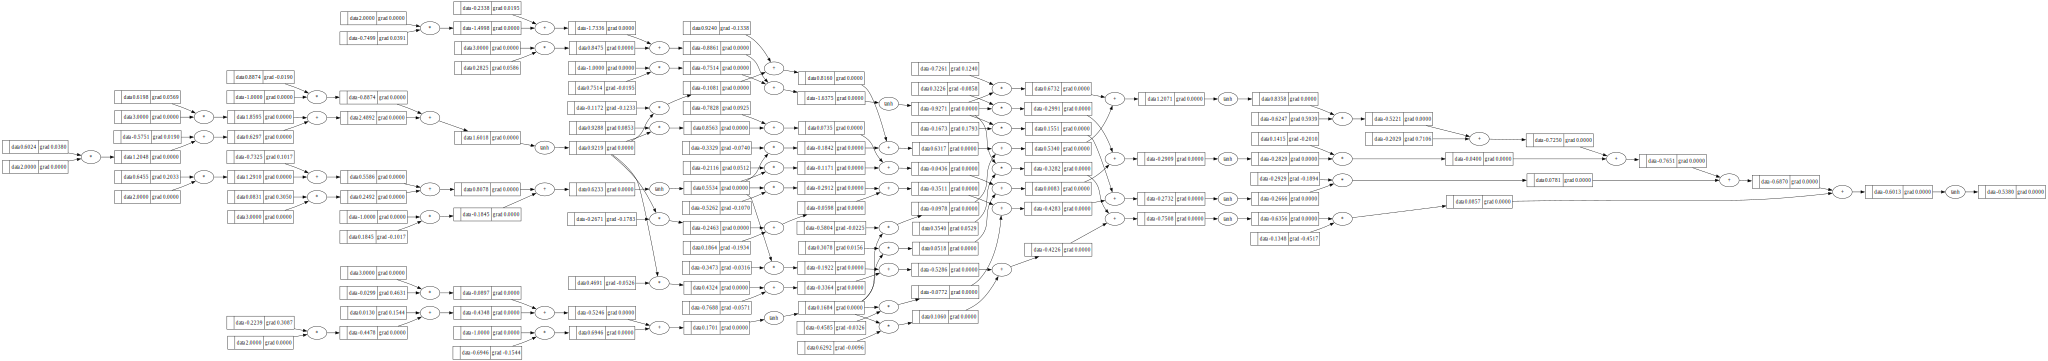

In [71]:
#Tensor with 3 values to represent the 3 scalar inputs that our MLP will recieve 
x = [2.0, 3.0, -1.0]
#Initialize our perception with 3 inputs and 4 neurons in the first layer and 4 neurons in the second layer, the final output is a single value
n = MLP(3, [4, 4, 1])
#Compute the output of the MLP
n(x)
#Perform backpropagation to compute the gradients
n(x).backward()
draw_dot(n(x))

In [72]:
#Dataset that has 4 examples, so 4 inputs into our MLP 
#We have also defined the desired targets for each of the examples
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

ypred = [n(x) for x in xs]

#Loss function
[(ypred - ys )**2 for ys, ypred in zip(ys, ypred)]

loss = sum([(ypred - ys )**2 for ys, ypred in zip(ys, ypred)])
loss.backward()

#The loss function is a scalar value that we can use to evaluate the performance of our neural network

In [ ]:
#loss.backward()
#What this line does: it tells us the gradient of this particular neuron that is in this particular layer 
n.layers[0].neurons[0].w[0].grad
#Even though the initial inputs have gradients, these gradients are not that useful to us, we are interested in the gradients of the weights and biases of the neurons in the network
draw_dot(loss)

In [80]:
#THis cell is gradient descent- aka we are computing the gradients in a descending manner aka right to left using the chain rule 

for k in range(40):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    # zero the gradients because pytorch accumulates them
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)
ypred

0 0.004771506968542856
1 0.004707057867581687
2 0.004644280975470327
3 0.00458311274631034
4 0.004523492794021893
5 0.004465363699141542
6 0.004408670829583594
7 0.004353362174204255
8 0.004299388188116664
9 0.004246701648802011
10 0.004195257522149775
11 0.0041450128376386485
12 0.00409592657193994
13 0.004047959540289427
14 0.0040010742950307805
15 0.003955235030784992
16 0.003910407495747766
17 0.0038665589086589692
18 0.003823657881025671
19 0.0037816743442165646
20 0.0037405794810756836
21 0.0037003456617329816
22 0.003660946383314754
23 0.0036223562132807335
24 0.0035845507361366873
25 0.0035475065032904724
26 0.0035112009858377434
27 0.0034756125300802643
28 0.003440720315593865
29 0.003406504315678204
30 0.0033729452600318095
31 0.0033400245995080674
32 0.0033077244728185167
33 0.0032760276750590338
34 0.003244917627944123
35 0.0032143783516419273
36 0.0031843944381109825
37 0.003154951025846101
38 0.0031260337759475457
39 0.0030976288494333373


[Value(data=0.976760224920368, grad=-0.04647955015926408),
 Value(data=-0.9655472187232866, grad=0.06890556255342672),
 Value(data=-0.9778339763871765, grad=0.04433204722564699),
 Value(data=0.9703484407968797, grad=-0.059303118406240696)]

In [79]:
ypred

[Value(data=0.9714704431283672, grad=-0.057059113743265666),
 Value(data=-0.9569039301584178, grad=0.08619213968316441),
 Value(data=-0.9721861063530561, grad=0.05562778729388773),
 Value(data=0.9626787505349371, grad=-0.07464249893012576)]

In [68]:
#These are the parameters for the weights and biases that allow this neural net to achieve our desired outputs
n.parameters()

[Value(data=0.49315735614652706, grad=0.0005210623517279917),
 Value(data=0.05299738188147827, grad=0.0002445116991345482),
 Value(data=-0.8740500504417615, grad=0.00036395748494107426),
 Value(data=0.4804509047324248, grad=0.0004646721098926183),
 Value(data=-0.42138346190780224, grad=-0.0005625302675770134),
 Value(data=1.1603763633212876, grad=-0.00013106317217775025),
 Value(data=-0.9571960213159505, grad=0.0018840134580377095),
 Value(data=-0.8547386197413507, grad=-0.0001245510629952612),
 Value(data=-0.23820454125567417, grad=-0.00019393399983285467),
 Value(data=0.6746635050939287, grad=9.132667686204731e-05),
 Value(data=-0.7052594471193785, grad=0.0014822368283009648),
 Value(data=-0.26842299603461467, grad=0.00015683076800114353),
 Value(data=0.31579290407466115, grad=4.760541404882785e-05),
 Value(data=-0.7215730216090102, grad=-0.00028595975597146616),
 Value(data=0.3839451431543281, grad=-0.00019876456762084067),
 Value(data=-0.7418992143844756, grad=-0.000176585562639151